# Notebook Examples for Chapter 2

In [ ]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%matplotlib inline

### Illustrating the central limit theorem

In [2]:
import numpy as np
import matplotlib.pyplot as plt

r = np.random.rand(10000,12)
array = np.sum(r,1)
p=plt.hist(array,bins=12)

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter2/fig2_1.eps')

### Chi-square density function

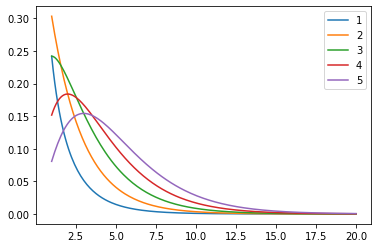

In [3]:
import scipy.stats as st

z = np.linspace(1,20,200)
ax = plt.subplot(111)
for i in range(1,6):
    ax.plot(z,st.chi2.pdf(z,i),label = str(i))
ax.legend()    

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter2/fig2_2.eps')

### Sampling

In [ ]:
import ee
ee.Initialize()

im = ee.Image(ee.ImageCollection('ASTER/AST_L1T_003') \
            .filterBounds(ee.Geometry.Point([6.5,50.9])) \
            .filterDate('2007-04-30','2007-05-02') \
            .first()) \
            .select('B3N')
roi = ee.Geometry.Polygon(
    [[6.382713317871094,50.90736285477543],
     [6.3961029052734375,50.90130070888041],
     [6.4015960693359375,50.90519789328594],
     [6.388206481933594,50.91169247570916],
     [6.382713317871094,50.90736285477543]])
sample = im.sample(roi,scale=15) \
           .aggregate_array('B3N').getInfo()
p = plt.hist(sample,bins=20)

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter2/fig2_4.eps')

### Confidence intervals

In [ ]:
from scipy.stats import norm,chi2

def x2(a,m):
    return chi2.ppf(1-a,m)

m = 1000
a = 0.05
g = np.random.random(m)
gbar = np.sum(g)/m
s = np.sum((g-gbar)**2)/(m-1)
print 'sample variance: %f'%s
lower = (m-1)*s/x2(a/2,m-1)
upper = (m-1)*s/x2(1-a/2,m-1)
print '%i percent confidence interval: (%f, %f)'\
               %(int((1-a)*100),lower,upper)
print 'sample mean: %f'%gbar
t = norm.ppf(1-a/2)
sigma = np.sqrt(s)
lower = gbar-t*sigma/np.sqrt(m)
upper = gbar+t*sigma/np.sqrt(m)
print '%i percent confidence interval: (%f, %f)'\
               %(int((1-a)*100),lower,upper)

### Provisional means

In [ ]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import auxil.auxil1 as auxil  

gdal.AllRegister()
infile = 'imagery/AST_20070501'                
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize
Xs = np.zeros((cols,3))
cpm = auxil.Cpm(3)
rasterBands=[inDataset.GetRasterBand(k+1)
             for k in range(3)]
for row in range(rows):
    for k in range(3):
        Xs[:,k]=rasterBands[k].ReadAsArray(0,row,cols,1)
    cpm.update(Xs)   
print cpm.covariance()

### Multiple linear regression

In [ ]:
import numpy as np

# biased data matrix X ( 3 independent variables)
X = np.random.rand(100,3)
X = np.mat(np.append(np.ones((100,1)),X,axis=1))
# a parameter vector
w = np.mat([[3.0],[4.0],[5.0],[6.0]])
# noisy dependent variable y with sigma = 0.1
y = X*w+np.random.normal(0,0.1,(100,1))
# pseudoinverse
Xp = (X.T*X).I*X.T
# estimated parameter vector
w = Xp*y
print w

In [ ]:
import tensorflow as tf

# set up computation graph
X1 = tf.constant(X)
y1 = tf.constant(y)
X1T = tf.transpose(X)
X1p = tf.matmul(tf.matrix_inverse(tf.matmul(X1T,X1)),X1T)
w = tf.matmul(X1p,y1)

# create and run a session to evaluate w 
with tf.Session() as sess:
    w = w.eval()
    
print w

In [ ]:
import ee
ee.Initialize()

# set up JSON description of the calculatiom
X1 = ee.Array(X.tolist())
y1 = ee.Array(y.tolist())
X1T = X1.matrixTranspose()
X1p = X1T.matrixMultiply(X1) \
         .matrixInverse() \
         .matrixMultiply(X1T)
w = X1p.matrixMultiply(y1)

# run on GEE server
print w.getInfo()

In [ ]:
print 0.01*(X.T*X).I

### Mutual information

In [ ]:
import numpy as np
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly

def mi(arr1,arr2): 
    '''mutual information of two uint8 arrays '''
    p12 = np.histogram2d(arr1,arr2,bins=256,
                         normed=True)[0].ravel()
    p1  = np.histogram(arr1,bins=256,normed=True)[0]
    p2  = np.histogram(arr2,bins=256,normed=True)[0] 
    p1p2 = np.outer(p1,p2).ravel()    
    idx = p12>0
    return np.sum(p12[idx]*np.log(p12[idx]/p1p2[idx]))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
 
gdal.AllRegister() 
infile = 'imagery/AST_20070501'
            
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize 
image = np.zeros((3,rows*cols)) 
# VNIR bands                                  
for b in range(3):
    band = inDataset.GetRasterBand(b+1)
    image[b,:]=np.byte(band.ReadAsArray(0,0,cols,rows))\
                                              .ravel()
inDataset = None

print mi(image[0,:],image[1,:])
print mi(image[0,:],image[2,:]) 
print mi(image[1,:],image[2,:]) 
